# 权重衰减

本节将介绍一些正则化技术

## 范数与权重衰减
首先回顾一下L1范数和L2范数的定义：

$$
\|x\|_1=\sum_{i}^{n}|x_i| = |x_1| + |x_2| + \cdots + |x_n|
$$

$$
\|x\|_2=\sqrt{\sum_{i}^{n}x_i^2} = \sqrt{|x_1|^2 + |x_2|^2 + \cdots + |x_n|^2}
$$

回顾线性回归的例子，给出损失函数
$$
L(\mathbf{w}, b) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{2}\left(\mathbf{w}^T \mathbf{x}^{(i)} + b - y^{(i)} \right)^2.
$$
其中 $\mathbf{x}^{(i)}$ 是样本 $i$ 的特征， $y^{(i)}$ 是样本 $i$ 的标签，$(\mathbf{w}, b)$ 是权重和偏置参数。为了惩罚权重向量的大小，我们以某种方式在损失函数中添加$\|\mathbf{w}\|^2$。并且通过正则化常数$\lambda$来描述这种权衡，这是一个非负超参数。
$$
L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2
$$

$L_2$正则回归的小批量随机梯度下降更新如下:

$$
\mathbf{w} \leftarrow (1 - \eta \lambda) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} x^{(i)} \left(\mathbf{w}^T \mathbf{x}^{(i)} + b - y^{(i)}\right).
$$

使用估计值和观测值之间的差异来更新权重$\mathbf{w}$。通常，网络输出层的偏置项不会被正则化。

## 高维线性回归

演示一下

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

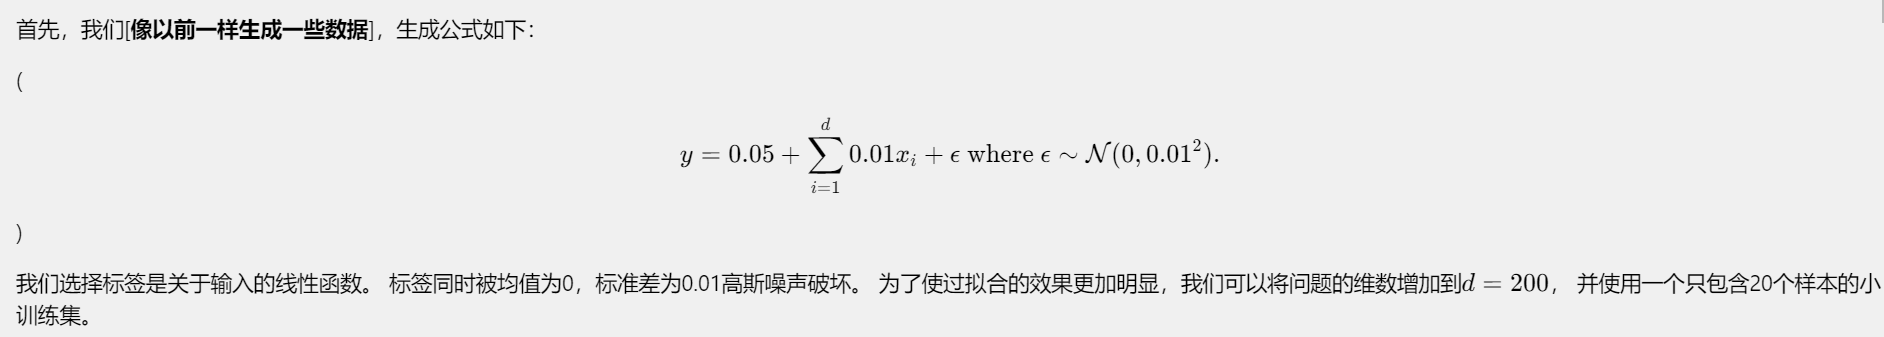

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 从零开始实现
只需将$L_2$的平方惩罚项加入到原始目标函数中即可

### 初始化模型参数
定义一个函数来随机初始化模型参数。

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义$L_2$范数惩罚
所有项求平方之后求和

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### 定义训练代码实现
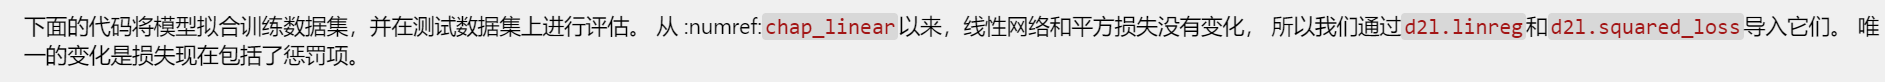

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range (num_epochs):
        for X, y in train_iter:
            # 增加L2范数惩罚项
            # 广播机制使得l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

下面使用忽略正则化和使用正则化权重衰减分别训练网络，并比较两种方法的结果。

w的L2范数是： 13.486849784851074


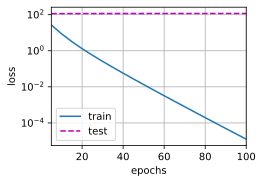

In [7]:
train(lambd=0)

测试误差没有减少而训练误差有了减少，这意味着严重的过拟合

w的L2范数是： 0.361871600151062


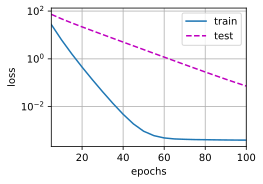

In [12]:
train(lambd=3)

测试误差和训练误差都在减小，这说明权重衰减有效果


### 简洁实现
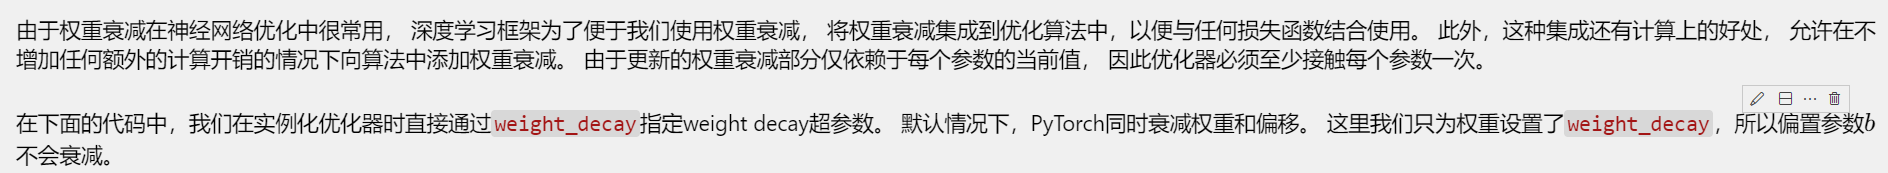



In [13]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.371695518493652


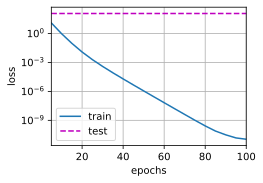

In [14]:
train_concise(0)

w的L2范数： 0.38848286867141724


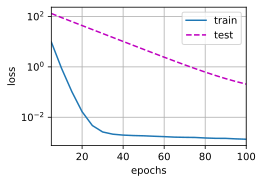

In [15]:
train_concise(3)